In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


In [2]:
# Loading the dataset
file_path = '/content/custo_seg.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()

,customer ID,Age,Gender,Climate,Religion,Purchase power
0,1048,60,1,3,3,88000
1,1049,29,0,2,2,37000
2,1050,43,1,1,1,55000
3,1051,34,0,0,0,46000
4,1052,56,1,3,3,82000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   customer ID     1000 non-null   int64
 1   Age             1000 non-null   int64
 2   Gender          1000 non-null   int64
 3   Climate         1000 non-null   int64
 4   Religion        1000 non-null   int64
 5   Purchase power  1000 non-null   int64
dtypes: int64(6)
memory usage: 47.0 KB


In [4]:
# Check for missing values
df.isnull().sum()



customer ID       0
Age               0
Gender            0
Climate           0
Religion          0
Purchase power    0
dtype: int64

In [5]:
df.describe()


,customer ID,Age,Gender,Climate,Religion,Purchase power
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20634.003000,46.61600,0.495000,1.523000,1.495000,52875.000000
std,9931.573866,15.32963,0.500225,1.110272,1.115894,19143.872724
min,1048.000000,20.00000,0.000000,0.000000,0.000000,15000.000000
25%,25688.750000,35.00000,0.000000,1.000000,1.000000,36000.000000
50%,25938.500000,46.00000,0.000000,2.000000,1.000000,51000.000000
75%,26189.250000,56.00000,1.000000,3.000000,2.000000,70000.000000
max,26439.000000,91.00000,1.000000,3.000000,3.000000,95000.000000


In [6]:
df.columns

Index(['customer ID', 'Age', 'Gender', 'Climate', 'Religion',
       'Purchase power'],
      dtype='object')

In [7]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['customer ID', 'Age', 'Gender', 'Climate',"Religion", 'Purchase power'])

# Displaying the first 10 records
duplicate_rows_sorted.head()

,customer ID,Age,Gender,Climate,Religion,Purchase power


# Observations
1. Missing Values Handled
2. duplicates values handled

In [8]:
df.shape


(1000, 6)

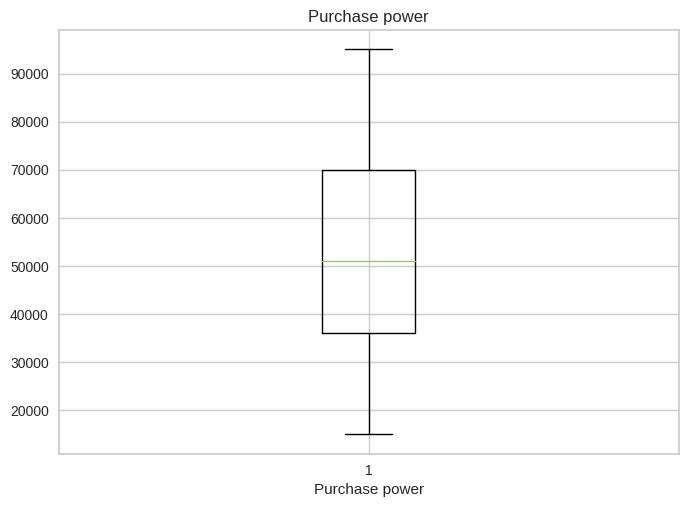

In [9]:
import matplotlib.pyplot as plt

# Create a boxplot of age
plt.boxplot(df['Purchase power'])
plt.xlabel('Purchase power')
plt.title('Purchase power')
plt.show()

1. Age do not have any outlier.
2. Purchase power do not have any Outlier either



SKEW VALUES handled

In [10]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

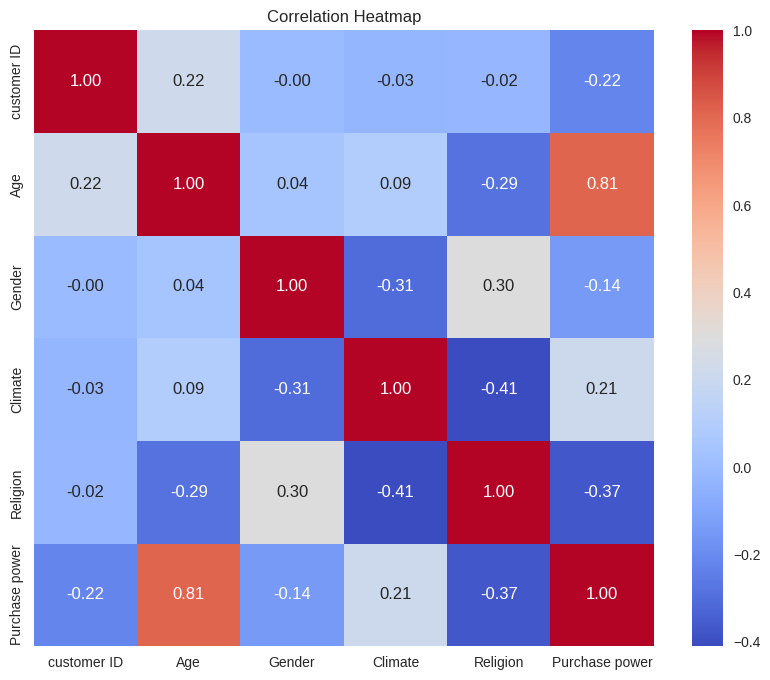

In [11]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

From this heatmap we can conclude that age and Purchase power are highly co-related


In [12]:
df['Religion'].describe()

count    1000.000000
mean        1.495000
std         1.115894
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Religion, dtype: float64

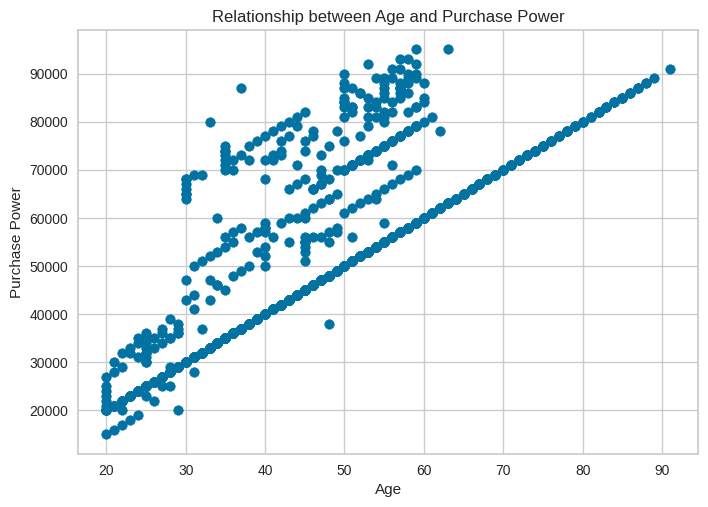

In [13]:
plt.scatter(df['Age'], df['Purchase power'])
plt.xlabel('Age')
plt.ylabel('Purchase Power')
plt.title('Relationship between Age and Purchase Power')
plt.show()

In [14]:
correlation = df['Age'].corr(df['Purchase power'])
print(correlation)

0.8088547570641452


In [15]:
#  1. Select relevant columns
features = ['Age', 'Purchase power']
X = df[features]

# 2. Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA
pca = PCA(n_components=1)  # Reduce to one component
principal_components = pca.fit_transform(X_scaled)

# 4. Create a new DataFrame with the principal component
df_pca = pd.DataFrame(data=principal_components, columns=['PC1'])

# 5. Optionally, add the principal component back to the original DataFrame
df = pd.concat([df, df_pca], axis=1)
df

,customer ID,Age,Gender,Climate,Religion,Purchase power,PC1
0,1048,60,1,3,3,88000,1.915712
1,1049,29,0,2,2,37000,-1.399636
2,1050,43,1,1,1,55000,-0.088349
3,1051,34,0,0,0,46000,-0.836292
4,1052,56,1,3,3,82000,1.509383
...,...,...,...,...,...,...,...
995,26435,32,0,1,3,32000,-1.445961
996,26436,54,1,0,1,54000,0.382345
997,26437,74,0,1,3,74000,2.044441
998,26438,42,1,3,2,42000,-0.614913


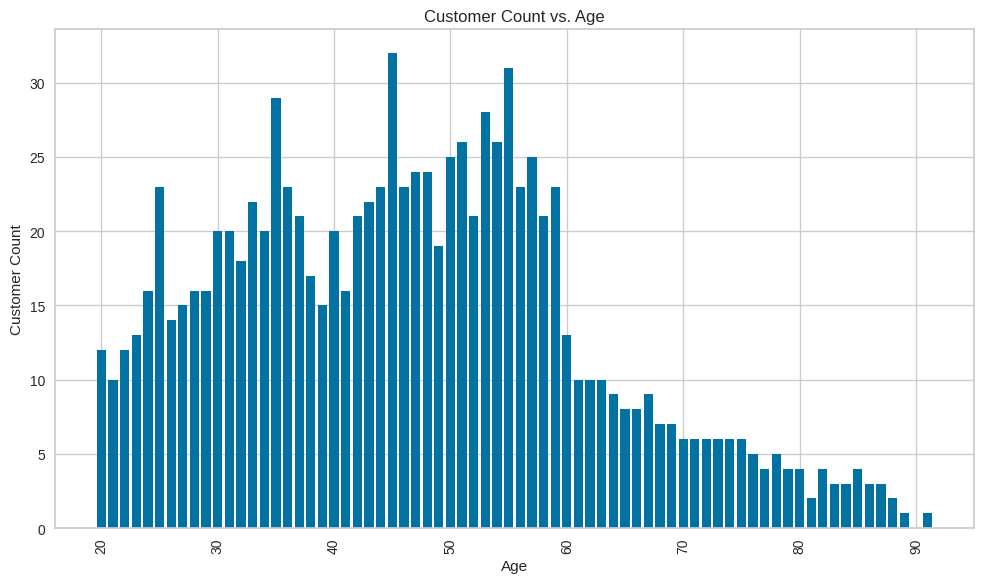

In [16]:
age_counts = df.groupby('Age')['customer ID'].count().reset_index(name='Customer Count')

plt.figure(figsize=(10, 6))
plt.bar(age_counts['Age'], age_counts['Customer Count'])
plt.xlabel('Age')
plt.ylabel('Customer Count')
plt.title('Customer Count vs. Age')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

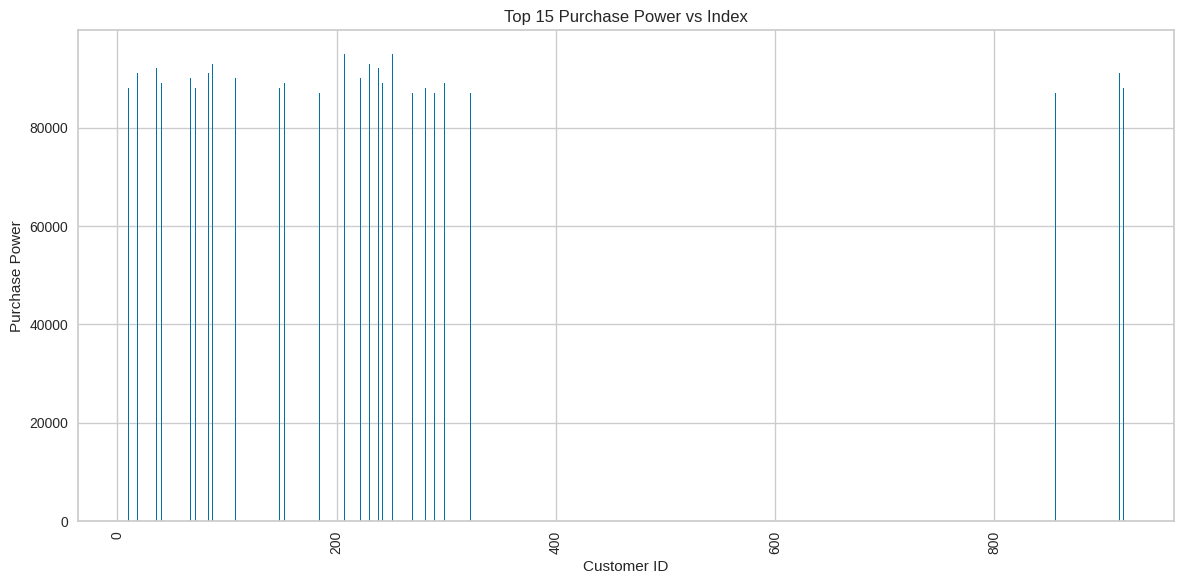

In [17]:
# Sort the dataframe by 'Purchase power' in descending order and select the top 15
top_15 = df.sort_values(by='Purchase power', ascending=False).head(30)

# Reset the index to start from 10
top_15.index = top_15.index + 10

plt.figure(figsize=(12, 6))
plt.bar(top_15.index, top_15['Purchase power'])
plt.xlabel('Customer ID')
plt.ylabel('Purchase Power')
plt.title('Top 15 Purchase Power vs Index')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

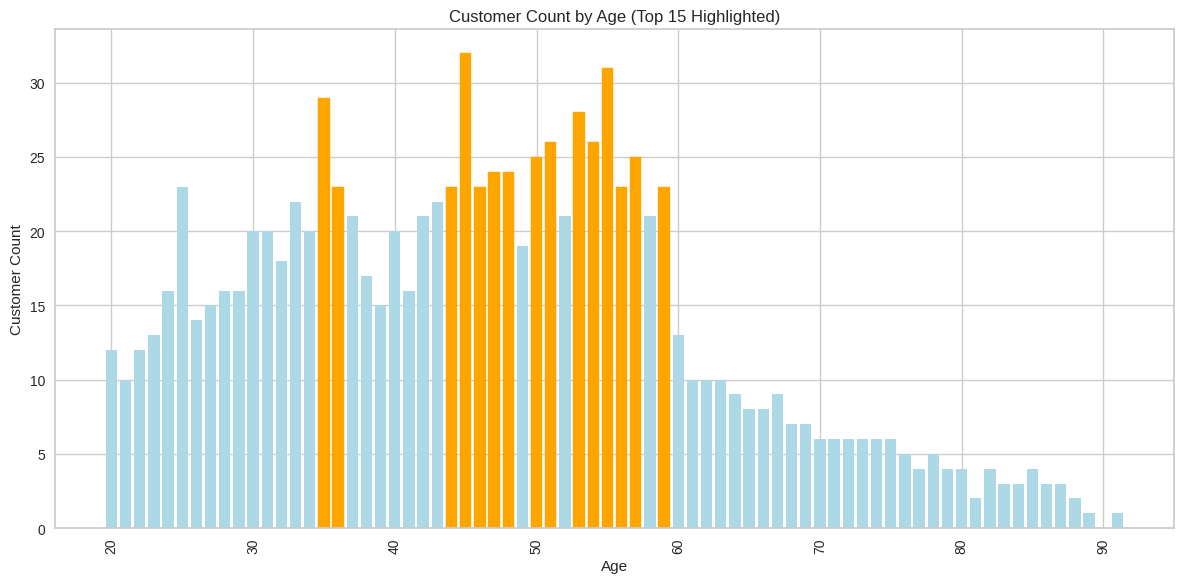

In [18]:
# Calculate customer counts for each age
age_counts = df.groupby('Age')['customer ID'].count().reset_index(name='Customer Count')

# Sort by customer count in descending order
age_counts_sorted = age_counts.sort_values('Customer Count', ascending=False)

# Select the top 15 ages
top_15_ages = age_counts_sorted.head(15)

# Create a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(age_counts_sorted['Age'], age_counts_sorted['Customer Count'], color='lightblue')

# Highlight the top 15 bars
for i in range(len(top_15_ages)):
    bars[i].set_color('orange')

plt.xlabel('Age')
plt.ylabel('Customer Count')
plt.title('Customer Count by Age (Top 15 Highlighted)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [19]:
import pickle
with open('Product_oriented.pkl', 'wb') as file:
    pickle.dump(bars, file)
